# Optotagging notebook

This notebook demonstrates the following:
- Reading data from an NWB file
- Plotting unit quality metrics
- Inspecting optotagging trial info and stimulus templates
- Aligning spike times to a laser stimulus

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

## Reading data from an NWB file

First, we find the NWB file of interest:

In [3]:
mouse_id = '625098'

nwb_file = glob.glob(os.path.join('/data','*' + mouse_id + '*', '*', '*.nwb.zarr'))[0]

print(nwb_file)

/data/ecephys_625098_2022-08-15_08-51-36_nwb/ecephys_625098_2022-08-15_08-51-36_nwb/ecephys_625098_2022-08-15_08-51-36_experiment1_recording1.nwb.zarr


Next, we can read it and inspect the contents using the `nwb2widget` tool:

In [4]:
io = NWBZarrIO(nwb_file, "r")
nwbfile_read = io.read()
nwb2widget(nwbfile_read)

Read in the units table as a Pandas `DataFrame`:

In [5]:
units = nwbfile_read.units[:]

Plot the waveform for one unit:

Text(0.5, 0, 'Time')

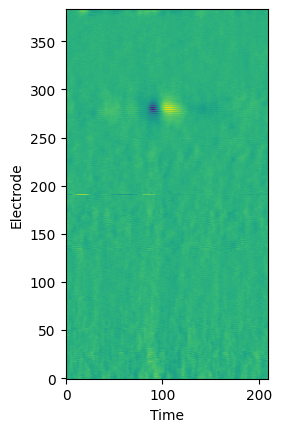

In [6]:
unit_index = 251

plt.imshow(units.waveform_mean.loc[unit_index].T, origin='lower')
plt.ylabel("Electrode")
plt.xlabel("Time")

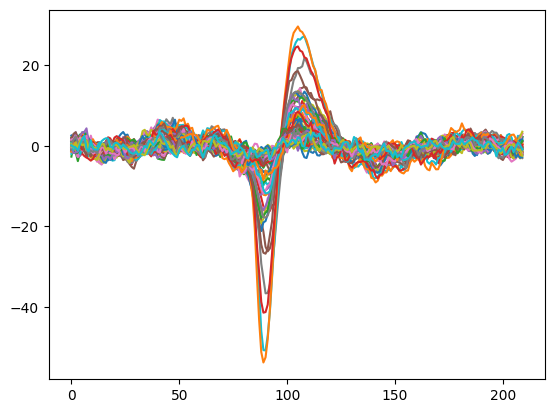

In [7]:
plt.plot(units.waveform_mean.loc[unit_index][:,250:300]);

What information do we have about each unit?

In [8]:
units.keys()

Index(['spike_times', 'electrodes', 'waveform_mean', 'waveform_sd',
       'unit_name', 'default_qc', 'presence_ratio', 'num_spikes', 'snr',
       'isi_violations_ratio', 'firing_rate', 'isolation_distance', 'l_ratio',
       'device_name', 'amplitude_cutoff', 'peak_to_valley',
       'repolarization_slope', 'amplitude', 'peak_trough_ratio', 'd_prime',
       'recovery_slope', 'half_width', 'ks_unit_id'],
      dtype='object')

In [9]:
units.iloc[0]

spike_times             [249.5327840854837, 249.55278609349838, 249.57...
electrodes              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
waveform_mean           [[2.9210987, -0.4338748, 4.8067503, -1.7403744...
waveform_sd             [[37.32225, 36.444195, 31.407179, 35.338566, 3...
unit_name                            ad0d033e-9a0f-4e3b-b162-fa620f1ad6ae
default_qc                                                           True
presence_ratio                                                        1.0
num_spikes                                                        52142.0
snr                                                             14.418345
isi_violations_ratio                                             0.000313
firing_rate                                                     20.410672
isolation_distance                                              93.642818
l_ratio                                                          0.242417
device_name                           

- `spike_times` - spike times (in seconds) for the entire session
- `electrodes` - electrode indices used for mean waveform
- `waveform_mean` - mean spike waveform across all electrodes
- `waveform_sd` - standard deviation of the spike waveform across all electrodes
- `unit_name` - universally unique identifier for this unit
- `default_qc` - `True` if this unit passes default quality control criteria, `False` otherwise
- `presence_ratio` - fraction of the session for which this unit was present (**default threshold = 0.8**)
- `num_spikes` - total number of spikes detected
- `snr` - signal-to-noise ratio of this unit's waveform (relative to the peak channel)
- `isi_violations_ratio` - metric that quantifies spike contamination (**default threshold = 0.5**)
- `firing_rate` - average firing rate of the unit throughout the session
- `isolation_distance` - distance to nearest cluster in Mahalanobis space (higher is better)
- `l_ratio` - related to isolation distance; quantifies the probability of cluster membership for each spike
- `device_name` - name of the probe that detected this unit
- `amplitude_cutoff` - estimated fraction of missed spikes (**default threshold = 0.1**)
- `peak_trough_ratio` - ratio of the max (peak) to the min (trough) amplitudes (based on 1D waveform)
- `repolarization_slope` - slope of return to baseline after trough (based on 1D waveform)
- `amplitude` - peak-to-trough distance (based on 1D waveform)
- `d_prime` - classification accuracy based on LDA (higher is better)
- `recovery_slope` - slope of return to baseline after peak (based on 1D waveform)
- `half_width` - width of the waveform at half the trough amplitude (based on 1D waveform)
- `ks_unit_id` - unit ID assigned by Kilosort

For more information about quality metrics, see the [ecephys_quality_metrics_tutorial](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) on the AllenSDK documentation site.

## Plotting unit quality metrics

Let's plot the distributions of some important metrics:

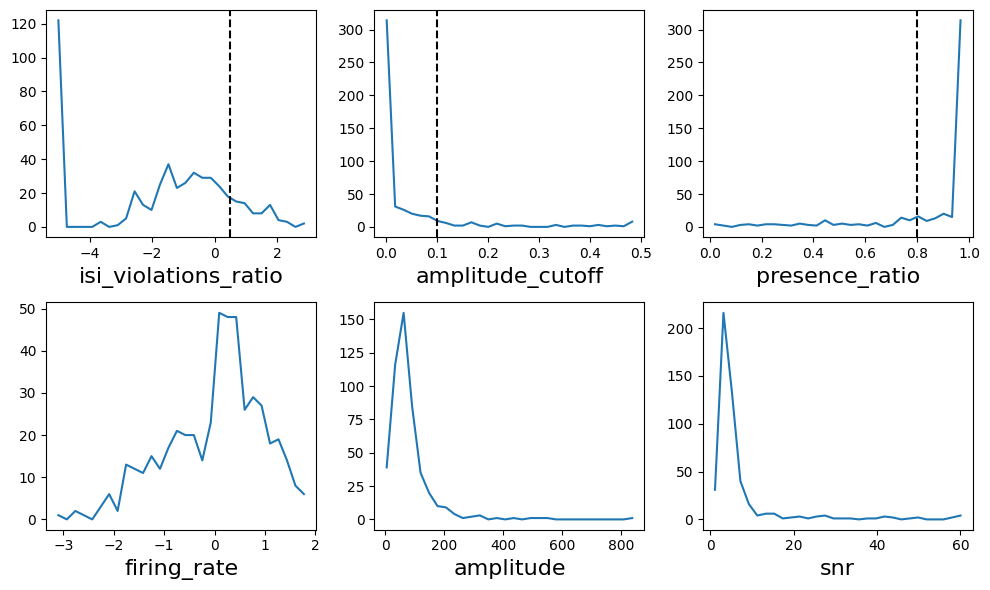

In [10]:
def plot_metric(metric, threshold=None, use_log=False):  
    m = units[metric].dropna()
    if use_log:
        m = np.log10(m+1e-5) # add small offset to avoid log(0)
    h,v = np.histogram(m, bins=30)
    plt.plot(v[:-1],h)
    plt.xlabel(metric, fontsize=16)
    if threshold:
        plt.axvline(x=threshold, ls='--', color='k')
        
qc_metrics = ['isi_violations_ratio','amplitude_cutoff','presence_ratio','firing_rate','amplitude','snr']
thresholds = [0.5, 0.1, 0.8, None, None, None]
use_log = [True, False, False, True, False, False]
plt.figure(figsize=(10,6))
for i, metric in enumerate(qc_metrics):
    plt.subplot(2,3,i+1)
    plot_metric(metric, thresholds[i], use_log[i])
    plt.tight_layout()


Finding units that pass default QC criteria:

In [11]:
units_passing_qc = units[units.default_qc=='True']

print(f'Total units: {len(units)}\nUnits passing QC: {len(units_passing_qc)}')

Total units: 485
Units passing QC: 219


In [12]:
extract_idx = list(set(units.index) - set(units_passing_qc.index))
units_failing_qc = units.loc[extract_idx]

Text(0, 0.5, 'Count')

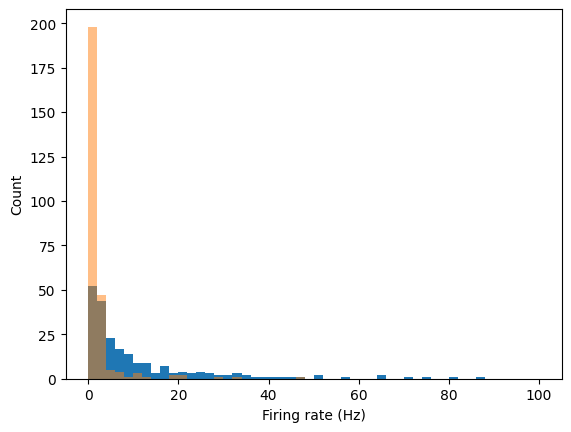

In [13]:
plt.hist(units_passing_qc.firing_rate, bins=50, range=(0,100));
plt.hist(units_failing_qc.firing_rate, bins=50, range=(0,100), alpha=0.5);
plt.xlabel("Firing rate (Hz)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

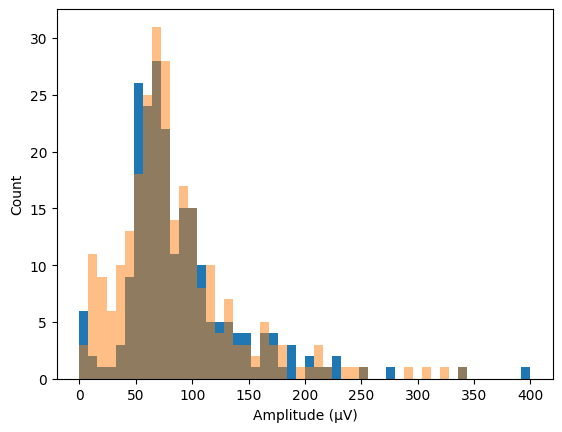

In [14]:
plt.hist(units_passing_qc.amplitude, bins=50, range=(0,400));
plt.hist(units_failing_qc.amplitude, bins=50, range=(0,400), alpha=0.5);
plt.xlabel("Amplitude (µV)")
plt.ylabel("Count")

In [15]:
start_time = int(nwbfile_read.epochs[:].start_time.min())
end_time = int(nwbfile_read.epochs[:].stop_time.max())
time_bins = np.arange(start_time,end_time,1)

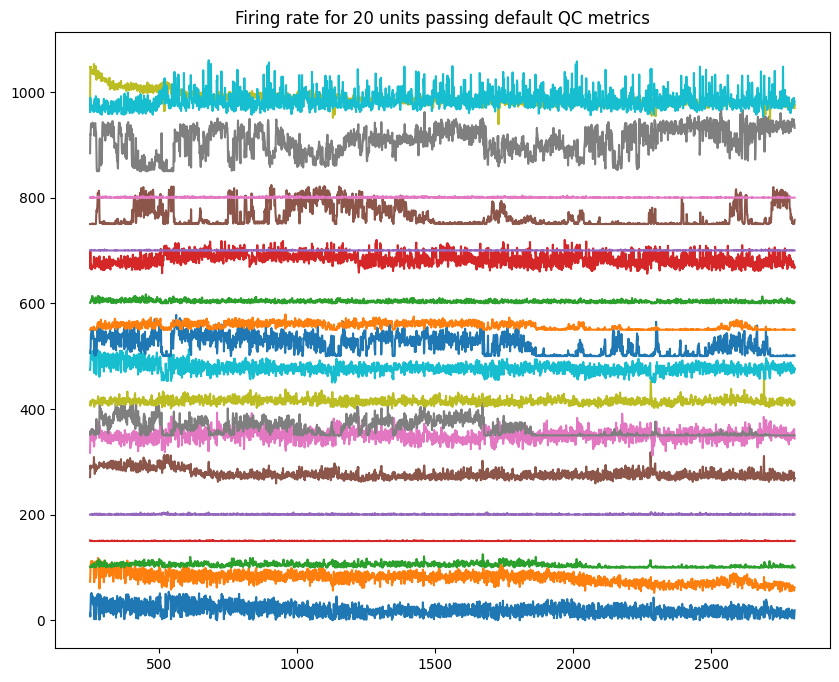

In [16]:
plt.figure(figsize=(10,8))
for i in range(20):
    h,v = np.histogram(units_passing_qc.spike_times.iloc[i], time_bins)
    plt.plot(v[:-1],h+(50*i))

_ = plt.title("Firing rate for 20 units passing default QC metrics")

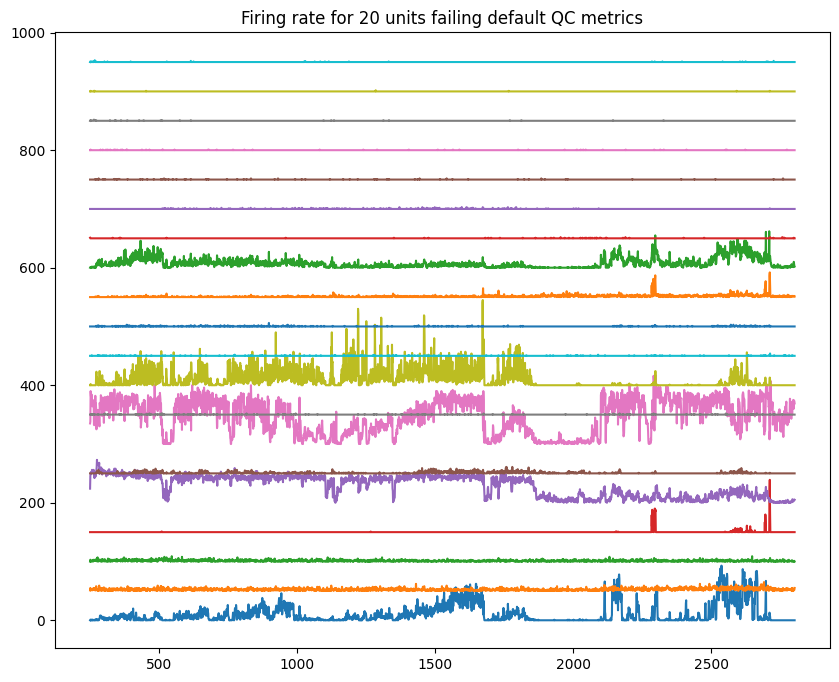

In [17]:
plt.figure(figsize=(10,8))
for i in range(20):
    h,v = np.histogram(units_failing_qc.spike_times.iloc[i], time_bins)
    plt.plot(v[:-1],h+(50*i))
_ = plt.title("Firing rate for 20 units failing default QC metrics")

## Optotagging trial info and stimulus templates

Let's read in the trials table:

In [18]:
trials = nwbfile_read.trials[:]

In [19]:
trials

,start_time,stop_time,site,power,param_group,duration,rise_time,num_pulses,wavelength,type,inter_pulse_interval,stimulus_template_name
id,,,,,,,,,,,,
0,486.826300,486.906300,14,0.06,short_pulse,0.01,0.001,1,638,internal_red,0.00,internal_red-short_pulse-0.06mW
1,486.986367,487.056367,12,0.01,train,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.01mW
2,487.414300,487.494300,12,0.06,short_pulse,0.01,0.001,1,638,internal_red,0.00,internal_red-short_pulse-0.06mW
3,487.569400,487.659400,6,0.01,train,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.01mW
4,487.976633,488.996633,0,10.00,short_pulse,0.01,0.001,1,638,external_red,0.00,external_red-short_pulse-10.0mW
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,2782.930667,2783.000667,3,0.06,long_pulse,0.10,0.020,1,638,internal_red,0.00,internal_red-long_pulse-0.06mW
5096,2783.216700,2783.306700,2,0.06,long_pulse,0.10,0.020,1,638,internal_red,0.00,internal_red-long_pulse-0.06mW
5097,2783.518833,2783.598833,3,0.01,train,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.01mW


In [20]:
trials.keys()

Index(['start_time', 'stop_time', 'site', 'power', 'param_group', 'duration',
       'rise_time', 'num_pulses', 'wavelength', 'type', 'inter_pulse_interval',
       'stimulus_template_name'],
      dtype='object')

In [21]:
trials.stimulus_template_name.unique()

array(['internal_red-short_pulse-0.06mW', 'internal_red-train-0.01mW',
       'external_red-short_pulse-10.0mW',
       'external_red-short_pulse-5.0mW', 'internal_red-long_pulse-0.06mW',
       'internal_red-train-0.06mW', 'external_red-long_pulse-1.0mW',
       'external_red-train-1.0mW', 'internal_red-short_pulse-0.01mW',
       'external_red-train-3.0mW', 'internal_red-long_pulse-0.01mW',
       'external_red-long_pulse-2.0mW', 'external_red-short_pulse-4.0mW',
       'external_red-train-4.0mW', 'external_red-train-5.0mW',
       'external_red-train-10.0mW', 'external_red-short_pulse-3.0mW',
       'external_red-long_pulse-3.0mW', 'external_red-long_pulse-4.0mW',
       'external_red-short_pulse-1.0mW', 'external_red-train-2.0mW',
       'external_red-long_pulse-10.0mW', 'external_red-long_pulse-5.0mW',
       'external_red-short_pulse-2.0mW'], dtype=object)

### Plot the stimulus templates
We'll pick on size (mW) but focus on the difference in the temporal patterns.

Text(0.5, 0, 'Time (s)')

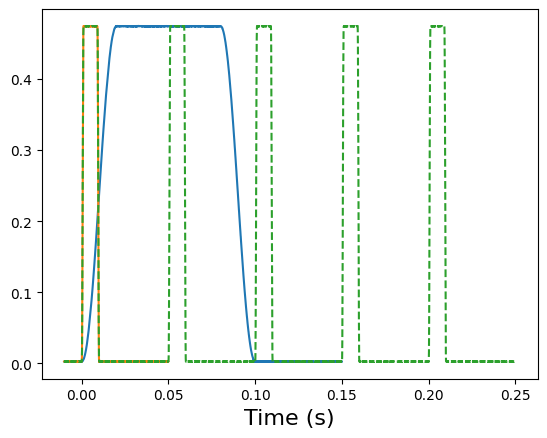

In [22]:
stimulus_template = nwbfile_read.stimulus_template

plt.plot(stimulus_template['external_red-long_pulse-1.0mW'].timestamps[:], stimulus_template['external_red-long_pulse-1.0mW'].data[:])
plt.plot(stimulus_template['external_red-short_pulse-1.0mW'].timestamps[:], stimulus_template['external_red-short_pulse-1.0mW'].data[:])
plt.plot(stimulus_template['external_red-train-1.0mW'].timestamps[:], stimulus_template['external_red-train-1.0mW'].data[:], ls='--')
plt.xlabel("Time (s)", fontsize=16)

"External" = laser aimed at the surface of the brain (site = 0)

In [23]:
trials[trials.type=='external_red'].site.unique()

array([0])

"Internal" = laser coupled into the Neuropixels Opto probe (light output through one of 14 emission sites)

In [24]:
trials[trials.type=='internal_red'].site.unique()

array([14, 12,  6, 10,  9,  8,  1,  3, 11,  2,  7,  4,  5, 13])

## Plot the mean response of each good unit to the external train stimulus

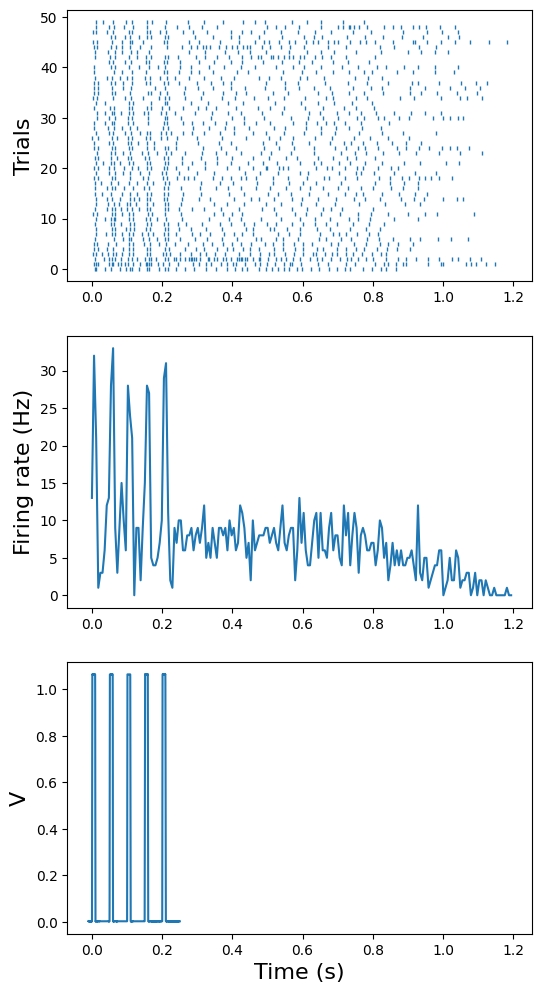

In [25]:
#get the trials for external train power 3.0 mW
subset = trials[(trials.param_group=='train')&(trials.site==0)&(trials.power==3)]
subset.reset_index(inplace=True)
tme = np.linspace(0,1.2,200)

#get the stimulus template
train_template = stimulus_template['external_red-train-3.0mW'].data[:]
train_ts = stimulus_template['external_red-train-3.0mW'].timestamps[:]

#make psth for one unit
unit_index = 5
spikes = units_passing_qc.spike_times.iloc[unit_index]
spike_trial = []
spike_trial_ts = []
for index,row in subset.iterrows():
    spike_trial_ts.append(spikes[(spikes>row.start_time)&(spikes<row.stop_time)] - row.start_time)
    spike_trial.append(np.ones(spikes[(spikes>row.start_time)&(spikes<row.stop_time)].shape)[:]*index)

spike_trial_ts = np.concatenate(spike_trial_ts)
spike_trial = np.concatenate(spike_trial)
h,v = np.histogram(spike_trial_ts, tme)

#plot
plt.figure(figsize=(6,12))
ax = plt.subplot(311)
ax.plot(spike_trial_ts, spike_trial, '|', markersize=3)
ax.set_ylabel("Trials", fontsize=16)
ax2 = plt.subplot(312, sharex=ax)
ax2.plot(v[:-1],h)
ax2.set_ylabel("Firing rate (Hz)", fontsize=16)
ax3 = plt.subplot(313, sharex=ax)
ax3.plot(train_ts, train_template)
ax3.set_xlabel("Time (s)", fontsize=16)
_ = ax3.set_ylabel("V", fontsize=16)

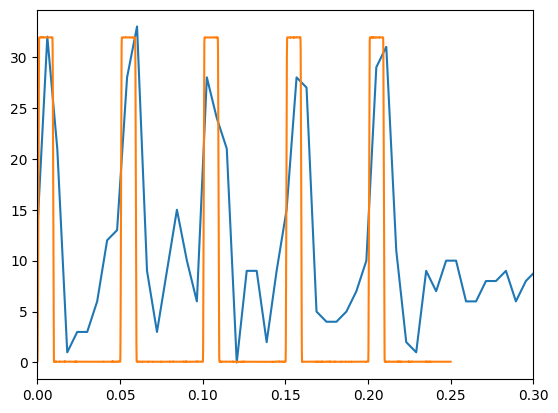

In [26]:
plt.plot(v[:-1],h)
plt.plot(train_ts, train_template*30)
_ = plt.xlim(0,0.3)

### Get the mean firing rate to one stimulus for all units passing QC

In [27]:
subset = trials[(trials.param_group=='train')&(trials.site==0)&(trials.power==3)]
subset.reset_index(inplace=True)
good_units = units[units.default_qc=='True']
good_units.reset_index(inplace=True)
tme = np.linspace(0,1.2,200)

psth_plot = np.empty((len(units_passing_qc), len(tme)-1))

for unit_index, unit_row in good_units.iterrows():
    spikes = unit_row.spike_times
    spike_trial = []
    spike_trial_ts = []
    for index,row in subset.iterrows():
        spike_trial_ts.append(spikes[(spikes>row.start_time)&(spikes<row.stop_time)] - row.start_time)
        spike_trial.append(np.ones(spikes[(spikes>row.start_time)&(spikes<row.stop_time)].shape)[:]*index)
    spike_trial_ts = np.concatenate(spike_trial_ts)
    spike_trial = np.concatenate(spike_trial)
    h = np.histogram(spike_trial_ts, tme)[0]
    psth_plot[unit_index, :] = h / np.max(h)

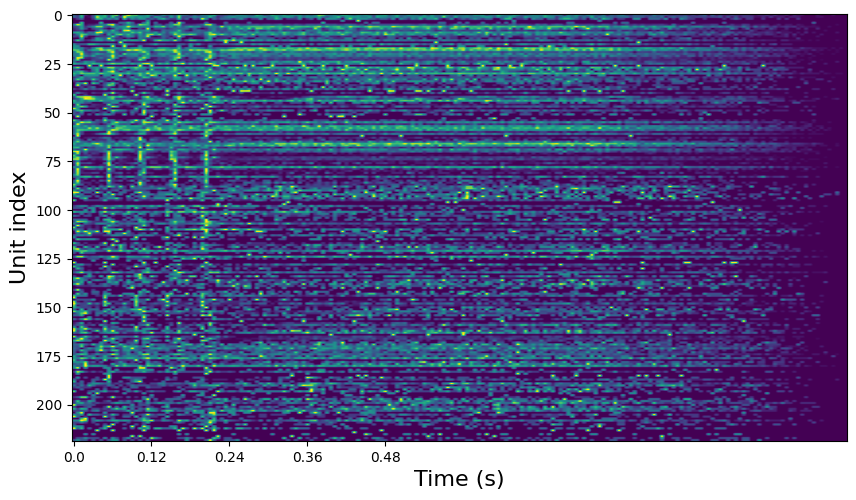

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(psth_plot, aspect=0.5)
plt.xticks(range(0,100,20), np.round(tme[range(0,100,20)],2));
plt.xlabel("Time (s)", fontsize=16)
_ = plt.ylabel("Unit index", fontsize=16)

Some interesting questions to explore:

- Are there temporal differences in the opto responses (i.e., do some units fire earlier than others)?
- Is it interesting to compare responses at different power levels?
- Which units respond to internal vs. external laser, or both? Does this vary with unit depth?
- Do some units respond to short vs long opto stim? (is this informative?)
- Are there differences between units that have opto responses vs those that don't? Can look at firing rate, waveform shape, location, inter-spike interval histogram, etc.